# Deconvolution by KanCell on human_heart dataset

In [ ]:
import sys
sys.path.append('/data/wzh/KanCell-main')


In [1]:
import pandas as pd
import scanpy as sc
import anndata
import os
from tqdm import tqdm 
import scanpy as sc
import numpy as np
import sys

## Load spatial transcriptomics data

The input data are anndata objects stored raw counts for scRNA-seq and ST. The scRNA-seq anndata must have cell type annotation in ``.obs``.

In [2]:
adata = sc.read('/data/KanCell-main/docs/data/humanheart/Spatial.h5ad')
scadata = sc.read_h5ad('/data/KanCell-main/docs/data/humanheart/scRNA.h5ad')
scadata.var_names_make_unique()
scadata.obs_names_make_unique()

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Initialize and train the KanCell_l model

In this step, we initialize the KanCell_l model using anndata objects for scRNA-seq and ST as input. The``celltype_key`` parameter represents the column name of the cell type annotation in the .obs attribute of the scRNA-seq anndata object. The ``sm_size`` parameter controls the number of simulated spots, and it is important to have a sufficient ``sm_size`` for accurate prediction. However, it should be noted that increasing the ``sm_size`` will also increase the simulation and training time. In general, we recommend setting ``sm_size`` to a value greater than 100,000.

In [7]:
import KanCell
from KanCell import KanCell_l
from KanCell.setting import set_environ_seed
set_environ_seed()


Setting environment seed: 42


Global seed set to 0


In [8]:
KanCell_l_model = KanCell_l.init_model(scadata,adata,celltype_key='celltype',sm_size=500000,use_gpu=True,n_threads=16)

Setting global seed: 42
### Finding marker genes...
celltype
Atrial cardiomyocytes                                    200
Capillary endothelium                                    200
Cardiac neural crest cells & Schwann progenitor cells    200
Endothelium / pericytes / adventitia                     200
Epicardial cells                                         200
Epicardium-derived cells                                 200
Erythrocytes                                             200
Fibroblast-like                                          200
Immune cells                                             200
Smooth muscle cells                                      200
Ventricular cardiomyocytes                               200
Name: count, dtype: int64
### Used gene numbers: 1911
### Initializing sample probability
### Genetating simulated spatial data using scRNA data with mode: unbalance
### Genetating simulated spatial data using scRNA data with mode: sqrt
### Genetating simulated spatia

In [9]:
import os,sys
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
KanCell_l_model.train(max_steps=5000, batch_size=1024)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 3/100:   2%|▏         | 2/100 [00:17<14:07,  8.65s/it, loss=727, v_num=1]

Epoch 100/100: 100%|██████████| 100/100 [13:52<00:00,  8.19s/it, loss=666, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [13:52<00:00,  8.33s/it, loss=666, v_num=1]


  0%|          | 0/5000 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 11.76 GiB total capacity; 1.86 GiB already allocated; 134.44 MiB free; 2.36 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Then, we utilize the trained model to predict the cell type composition of each spot in the spatial transcriptomics data. This prediction will generate a DataFrame object, where each row corresponds to a spot in the spatial transcriptomics data, each column represents a cell type from the single-cell RNA-seq data, and each entry indicates the proportion of a particular cell type in a spot. Additionally, we can obtain the anndata object of the spatial transcriptomics data with the deconvolution results embedded in the .obs attribute.

In [ ]:
pre = KanCell_l_model.deconv_spatial()
st_ad = KanCell_l_model.st_ad
# st_ad.write('../data/ST_mouse_brain/mouse_brain_st.h5ad')

## Visualization results

As a demonstration, we plotted the predicted compositions of cell types on a slice, where the cell types are selected as the top 20 with the highest proportion within each spot.

In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=50,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3,3))
sc.settings.verbosity = 3

In [ ]:
from skimage.io import imread
st_loc_file="/data/SpatialcoGCN-main/data/pseudo_STData/realdata/humanheart/Data/Human_heart_ST_location.txt"
st_loc_df = pd.read_csv(st_loc_file, sep = "\t", index_col = 0, header = 0)


# 将 DataFrame 转换为 NumPy 数组
spatial_coords = st_loc_df.values

# 将空间坐标数据存储在 adata.obsm['spatial'] 中
st_ad.obsm['spatial'] = spatial_coords

# 现在 adata.obsm['spatial'] 中应该包含了位置信息
print(st_ad.obsm['spatial'])
# adata_st_list_raw = []
# for i in range(1, 10):
img_i = imread('/data/GraphST-main/Data/humanheart/dgnysc3zn5-1/ST_Samples_9PCW/ST_Sample_9PCW_1/ST_Sample_9PCW_1_HE_small.jpg')

# 创建与示例相同结构的数据字典
st_ad.uns['spatial'] = {}
st_ad.uns['spatial']['0'] = {}
st_ad.uns['spatial']['0']['images'] = {}
st_ad.uns['spatial']['0']['images']['hires'] = img_i
st_ad.uns['spatial']['0']['scalefactors'] = {'spot_diameter_fullres': 10,
                                                'tissue_hires_scalef': 2.0,
                                                'fiducial_diameter_fullres': 100,
                                                'tissue_lowres_scalef': 1.0}

    # 现在 adata.obsm 中应该包含了位置信息
print(st_ad.uns['spatial'])


[[17 20  1]
 [17 21  1]
 [17 22  1]
 ...
 [ 9 13 19]
 [ 9  8 19]
 [ 9  9 19]]
{'0': {'images': {'hires': array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
       

In [ ]:
# st_ad = st_ad[st_ad.obs.slice==37]
celltype = st_ad.obs.loc[:,pre.columns].max(0)

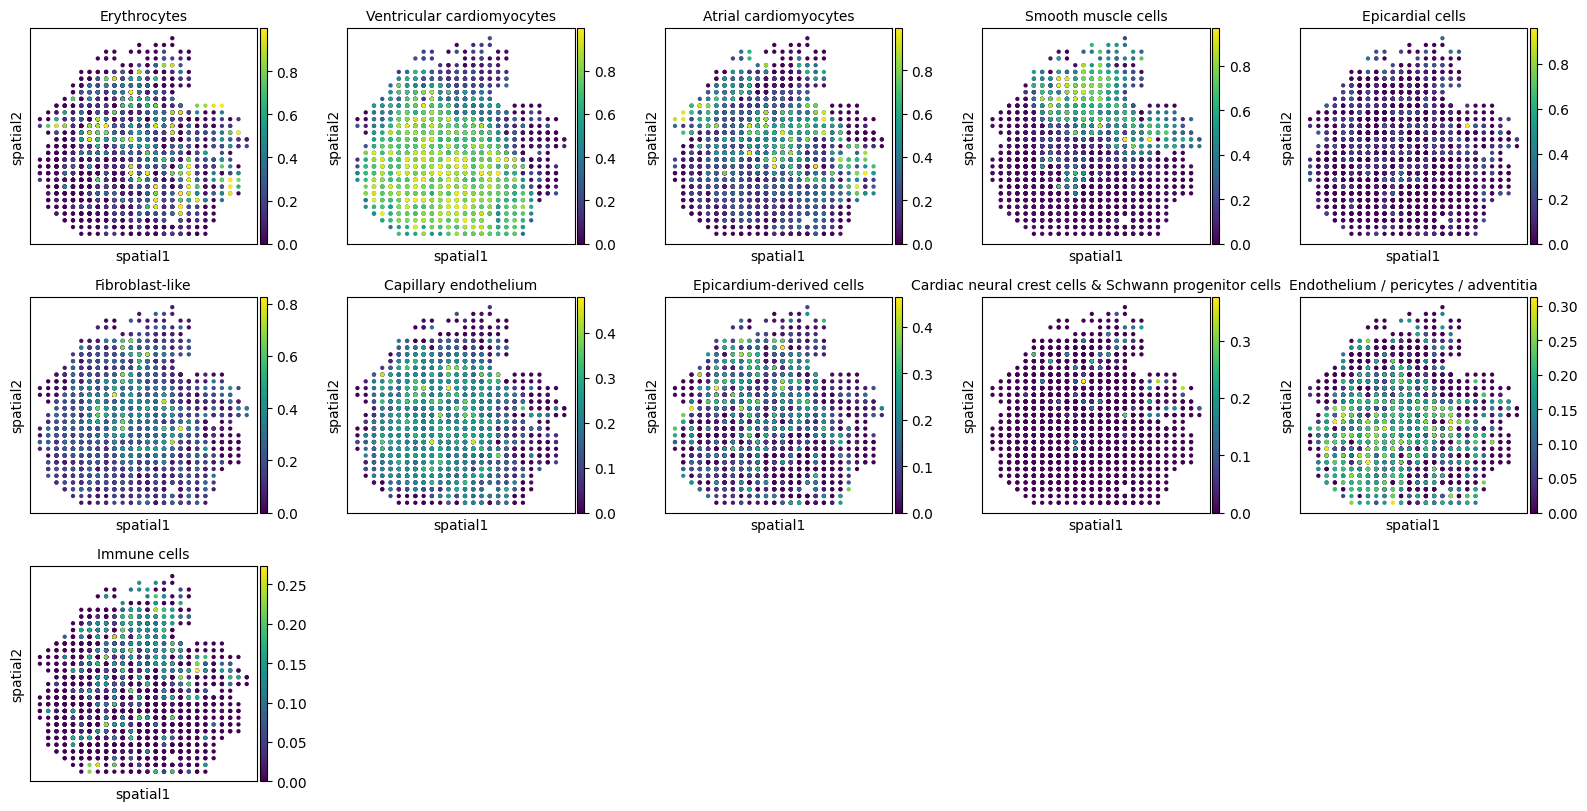

In [ ]:
sc.pl.embedding(st_ad,color=celltype.sort_values(ascending=False)[:20].index,basis='spatial',ncols=5)

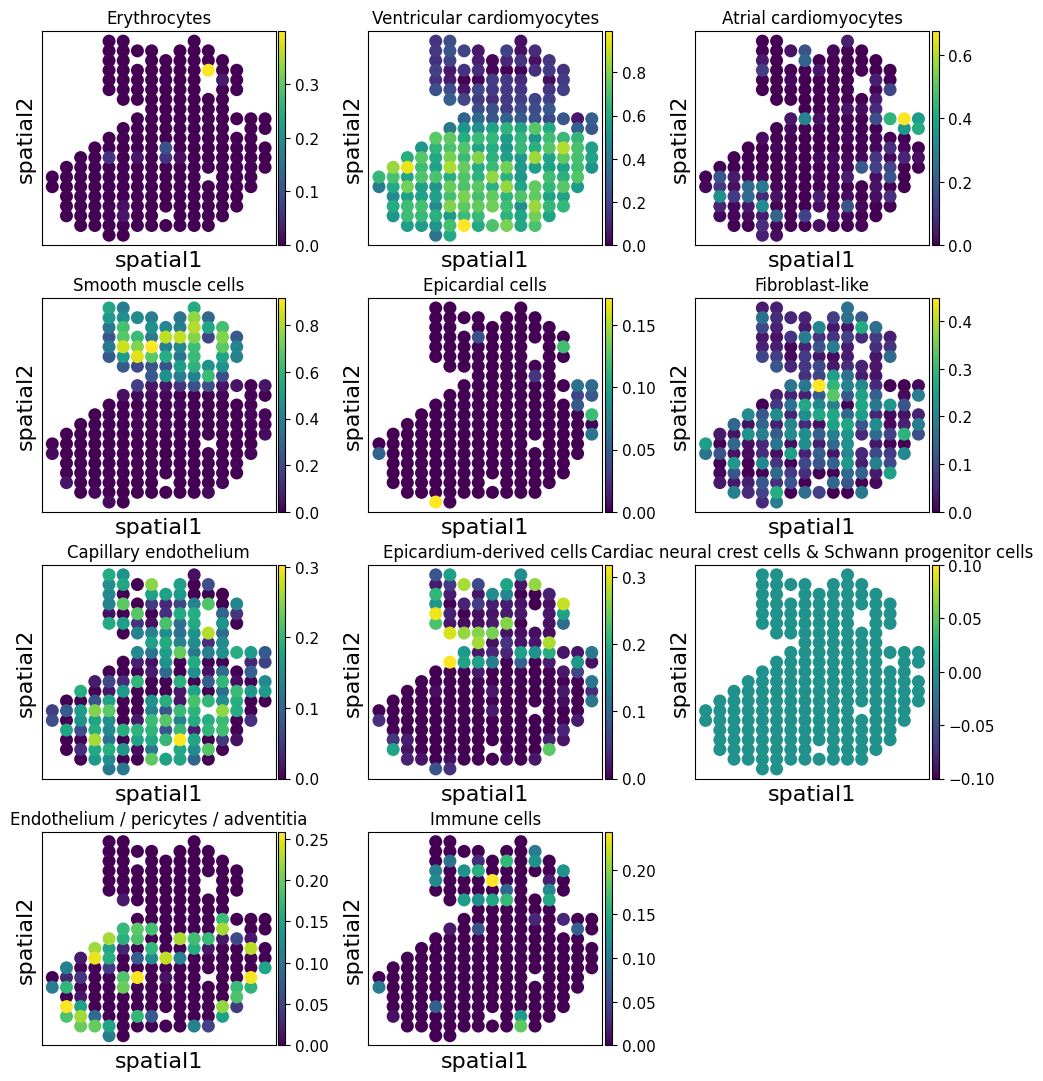

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
st_loc_file = "/data/SpatialcoGCN-main/data/pseudo_STData/realdata/humanheart/Data/Human_heart_ST_location.txt"
st_loc_df = pd.read_csv(st_loc_file, sep="\t", index_col=0, header=0)

# 将第三列转换为字符串类型
st_loc_df.iloc[:, 2] = st_loc_df.iloc[:, 2].astype(str)

# 对第三列进行筛选，只保留值为 "9" 的行
filtered_data = st_loc_df[st_loc_df.iloc[:, 2] == "19"]

# 使用筛选后的索引来从原始数据中获取想要的数据
filtered_adata = st_ad[filtered_data.index]

# 更新字体大小
plt.rcParams.update({'font.size': 14})  # 设置全局字体大小

# 绘制嵌入图，并调整颜色
sc.pl.embedding(
    filtered_adata, 
    color=celltype.sort_values(ascending=False)[:20].index, 
    basis='spatial', 
    ncols=3, 
    s=350, 
    size=10, 
    show=False
)

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.9, hspace=0.8)  # 调整水平和垂直间距

# 调整每个子图的字体大小
fig = plt.gcf()
axes = fig.get_axes()
for ax in axes:
    ax.title.set_size(12)  # 设置标题字体大小
    ax.xaxis.label.set_size(16)  # 设置x轴标签字体大小
    ax.yaxis.label.set_size(16)  # 设置y轴标签字体大小
    ax.tick_params(axis='both', which='major', labelsize=11)  # 设置刻度字体大小

# 显示图像
plt.show()
